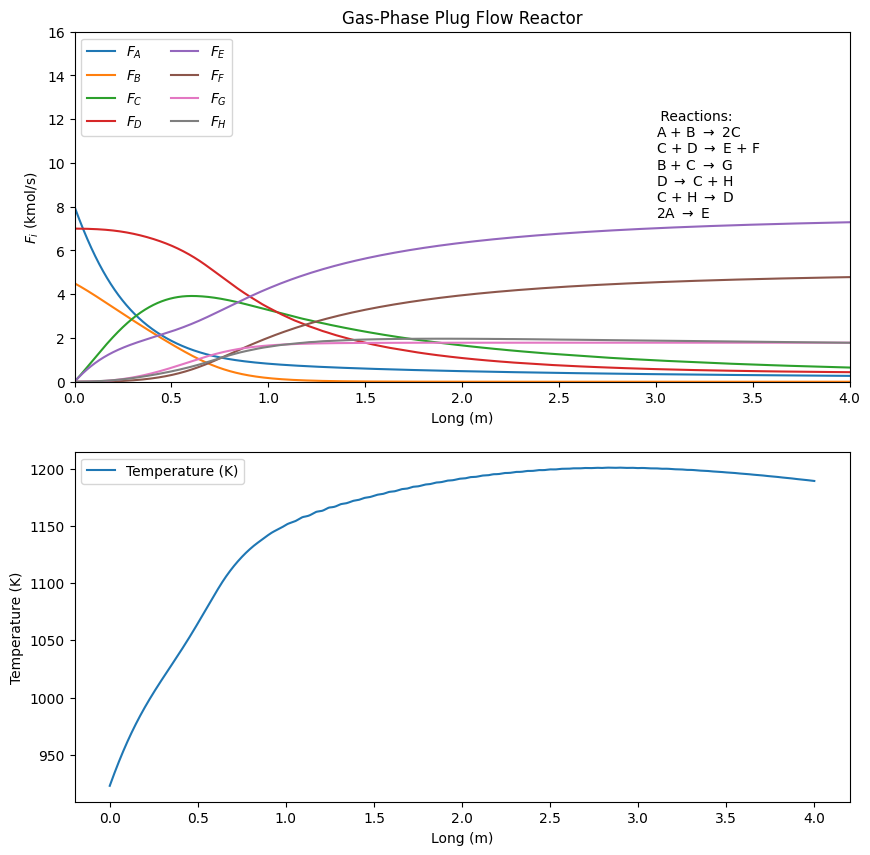

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

a, b, c, d, e, f, g, h = np.arange(8)

R1, R2, R3, R4, R5, R6 = np.arange(6)

# R-gas constant
Rg = 8.314 # kJ/kmol/K

# Pre-exponential factor
k = np.array([1.9e12, 6.9e14, 1.5e14, 3.2e16, 7.4e13, 7.2e8]) # s-1

# Activation of Energy
Ea = np.array([103930, 176020, 148010, 251020, 129710, 42450]) # kJ/kmol

# Thermodynamic data
Tref = 298 # K

dHref = np.array([-7100, 12300, -9200, 13500, -13500, -5800]) # kJ/kmol

Cp = np.array([41, 74, 56, 40, 29, 22, 35, 49]) # kJ/kmol/K

# Initial operation conditions of reactor
P0 = 130 # Pa
T0 = 650+273 # K

# Reactor data
L0 = 4 # Length of reactor (m)
D = 0.3 # Diameter of reactor (m)
S = np.pi*((D/2)**2) # cross section of reactor (m2)
U = 25 # Thermal coefficient (kJ/m2/s/K)

# Feed
FA0 = 480/60 # kmol/s
FB0 = 270/60 # kmol/s
FD0 = 420/60 # kmol/s

Fi0 = np.array([FA0, FB0, 0, FD0, 0, 0, 0, 0]) # Initial molar flow

Qv0 = sum(Fi0)*Rg*T0/P0 # Initial volumetric flow rate

alfa = np.array([
        # A,  B, C, D, E, F, G, H
        [-1, -1, 2, 0, 0, 0, 0, 0],  # R1
        [ 0,  0,-1,-1, 1, 1, 0, 0],  # R2
        [ 0, -1,-1, 0, 0, 0, 1, 0],  # R3
        [ 0,  0, 1,-1, 0, 0, 0, 1],  # R4
        [ 0,  0,-1, 1, 0, 0, 0,-1],  # R5
        [-2,  0, 0, 0, 1, 0, 0, 0],  # R6
        ], dtype=float)

Nreactions, Ncomponents = alfa.shape

def diff_eqs(L, y):

    F = y[:-2] # kmol/s
    Q = y[-2]  # kJ
    T = y[-1]  # K

    # Mass balance
    Qv = Qv0*sum(F)*T/sum(Fi0)/T0
    C = F/Qv
    ri = np.ones(Nreactions)

    # Reaction rate equations
    ri[a] = k[R1]*np.exp(-Ea[R1]/(Rg*T))*C[a]*C[b]
    ri[b] = k[R2]*np.exp(-Ea[R2]/(Rg*T))*C[c]*C[d]
    ri[c] = k[R3]*np.exp(-Ea[R3]/(Rg*T))*C[b]*C[c]
    ri[d] = k[R4]*np.exp(-Ea[R4]/(Rg*T))*C[d]
    ri[e] = k[R5]*np.exp(-Ea[R5]/(Rg*T))*C[c]*C[g]
    ri[f] = k[R6]*np.exp(-Ea[R6]/(Rg*T))*C[a]*C[a]


    # Mass balance
    dFdL = np.dot(ri, alfa)*S # vector elements (ri) = matrix rows (alfa)

    # Energy balance (The reactor is cooled with water at a Tc of 10oC)
    Tc = 10 + 273.15
    q = U*(np.pi*D)*(Tc-T)

    dQdL = q

    # Enthalpy
    dCp = np.dot(Cp, alfa.T)   # vector elements (Cp) = matrix rows (alfa.T)
    dH = dHref + dCp * (T-Tref)
    rH = np.dot(ri, dH)

    # Differential equations
    nCp = np.dot(Cp, F)
    dTdL = (dQdL-S*rH)/ nCp

    # output vector
    dy = np.hstack((dFdL, dQdL, dTdL))

    return dy


Q0 = 0 # Initial
y0 = np.hstack([Fi0, Q0, T0])
L  =  np.linspace(0, L0, 10000)   # length of the reactor gride

sol = solve_ivp(diff_eqs, [L[0], L[-1]], y0, t_eval=L)

F_kmol_s = sol.y[:-2]
Q = sol.y[-2] # heat
T = sol.y[-1] # K
L = sol.t     # length (m)

fig, ax = plt.subplots(nrows=2, ncols=1,  figsize=(10,10))

ax[0].plot(L, F_kmol_s[a], L, F_kmol_s[b], L, F_kmol_s[c], L, F_kmol_s[d], L,
           F_kmol_s[e], L, F_kmol_s[f], L, F_kmol_s[g], L, F_kmol_s[h])
ax[0].legend(['$F_A$','$F_B$','$F_C$','$F_D$','$F_E$','$F_F$','$F_G$','$F_H$'],
             loc='upper left', fontsize = 10, ncol=2)
ax[0].set_title('Gas-Phase Plug Flow Reactor')
ax[0].set_xlim([0, 4])
ax[0].set_ylim([0, 16])

ax[0].set_xlabel('Long (m)')

ax[0].set_ylabel('$F_{i}$ (kmol/s)')


ax[0].text(3, 7.5, r''' Reactions:
A + B $\rightarrow$ 2C
C + D $\rightarrow$ E + F
B + C $\rightarrow$ G
D $\rightarrow$ C + H
C + H $\rightarrow$ D
2A $\rightarrow$ E''')

ax[1].plot(sol.t, T)
ax[1].set_xlabel('Long (m)')
ax[1].set_ylabel('Temperature (K)' )
ax[1].legend(['Temperature (K)'])